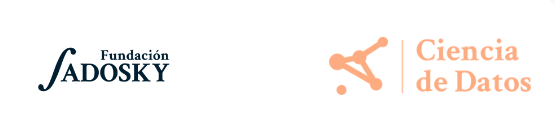

# **ENTREGA 2 - PROYECTO INTEGRADOR 2024**

## Objetivos

El malware que afecta a dispositivos móviles es un problema muy común en el día. La detección de malware es esencialmente un problema de clasificación de software basado en la información recopilada del análisis del programa, por lo cual nos interesa desarrollar un modelo de clasicación que más allá de indetificar una categoria de malware nos ayude a detectar la potencial presencia de estas amenazas.

Para el desarrollo de nuestro modelo de clasificación nos enfocaremos en 2 variables objetivo: *Category* y *Family*, por lo cual al final se tendran 2 modelos separados aunque entrenado con el mismo conjunto de datos.

Ademas por otro lado, aplicaremos técnicas de clustering y reducción de la dimensionalidad para conocer mas el dataset y entender la importancia de las variables para la clasificación.

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
pathCurso = '/content/drive/MyDrive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Comenzamos por importar el dataset con el que estabamos trabajando.

In [ ]:
data_path = pathCurso + '/full-dataset-CCCS-CIC-AndMal-2020.csv'
malware_df = pd.read_csv(data_path)
malware_df.shape

(53439, 145)

## Exploración de variables objetivo

Buscaremos entrenar un modelos de **aprendizaje supervisado** para predicir tanto categoias como familias de malware. Es decir, tendremos 2 variable target a predecir *Category* y *Family*. Recordemos que existian 14 categorias de malware posibles.

Para entrenar el modelo usaremos las 75 variables numéricas seleccionadas y no incluiremos la variable *Hash* ni *Reboot*. Además como estamos interesados tener un modelo que prediga categorias excluiremos la categoría *No_Category*
ya que no es una categoria en sí, no define algún comportamiento específico de malware y puede generar confusion con las otras categorias.

Tambien excluiremos la categoria *Zero_Day* porque tiene 2576 familias diferentes y la mayoria son de la forma: "SINGLETON:hash" que no parece ser un nombre de familia en sí.


In [ ]:
malware_df[malware_df['Category'] == 'Zero_Day'].Family

14395    SINGLETON:939abef572e3cac26239b8e74a255eba
14396    SINGLETON:3e0c507d2ae5921e429956cd4ad95b28
14397    SINGLETON:d707b76d22f89cff50708d34e9f1a04b
14398    SINGLETON:32b5e16967a9dc1ffe11cb613fefb48b
14399    SINGLETON:3cd16db36aa407ee0f5fcb9e4b0073eb
                            ...                    
30451    SINGLETON:d7445193a7cb7f4141e15535b60d08ea
30452    SINGLETON:8e61088ece4d149576b2b3877e6147f8
30453    SINGLETON:ab64c9bae471b996330bcfdb3a170faa
30454    SINGLETON:1f89404816dcd1005ac95a9b6c1ce17d
30455    SINGLETON:1720b06551fec56fec4a55ada49316e0
Name: Family, Length: 4475, dtype: object

In [ ]:
# Excluimos las 2 categorias mencionadas y limpiamos el dataset
malware_df = malware_df.drop(malware_df[
    malware_df['Category'] == 'No_Category'].index)
malware_df = malware_df.drop(malware_df[
    malware_df['Category'] == 'Zero_Day'].index)
malware_df.shape

(47032, 145)

Sobre la variable categoria *Family* habiamos visto que casi todas las categorias tenian un porcentaje de valor ```<unkown>```. Deberiamos ver tambien si los nombres de familia son mutuamente excluyentes entre categorias.  Es decir, comprobamos que el unico valor compartido entre categorías es ```<unkwown>```

In [ ]:
family_by_category = malware_df.groupby(['Category',
                                         'Family']).Memory_HeapSize.count()
categories = malware_df["Category"].unique()
for cat in categories:
  set_family = set(family_by_category[cat].index)
  for cat_to_compare in categories:
    if cat != cat_to_compare:
        res = set_family & set(family_by_category[cat_to_compare].index)
        assert res != {"unknown"}

Luego de esto eliminamos los datos que sean "unknown"

In [ ]:
  malware_df = malware_df.drop(
      malware_df[malware_df['Family'] == '<unknown>'].index)

A su vez debemos verificar que cada familia tenga una cierta cantidad de muestras para que podemos entrar correctamente un modelo. En este caso esperamos que cada familia tenga como minimo 10 datos.

In [ ]:
family_by_category = malware_df.groupby(['Category',
                                         'Family']).Memory_HeapSize.count()
families_to_delete = []
print("FAMILIAS con cantidad insuficiente de datos")
for cat in categories:
  print("** Categoría:", cat)
  for fam in family_by_category[cat].index:
    if family_by_category[cat][fam] <= 10:
      families_to_delete.append(fam)
      print("\t", fam)

FAMILIAS con cantidad insuficiente de datos
** Categoría: PUA
	 wiyun
** Categoría: Adware
	 accutrack
	 batmobi
	 ganlet
	 gmobi
	 hiddenad
	 kalfere
	 kyhub
	 plague
	 xynyin
** Categoría: FileInfector
** Categoría: Trojan
	 cnsms
	 coinge
	 droiddreamlight
	 drosel
	 gluper
	 obtes
	 oveead
	 uten
	 uupay
	 walkfree
	 wintertiger
	 zbot
** Categoría: Ransomware
** Categoría: Trojan_Spy
	 smszombie
	 spyoo
	 tekwon
** Categoría: Riskware
	 badpac
	 deng
	 kingroot
	 secneo
	 tencentprotect
	 tordow
** Categoría: Trojan_SMS
** Categoría: Trojan_Dropper
	 boqx
	 gorpo
	 xiny
** Categoría: Trojan_Banker
	 bankbot
	 fakebank
	 guerrilla
	 gugi
	 wroba
** Categoría: Backdoor
	 levida
** Categoría: Scareware
	 mobwin


Luego tambien eliminamos estas filas con valores insuficientes para las familias

In [ ]:
for fam in families_to_delete:
  malware_df = malware_df.drop(malware_df[malware_df['Family'] == fam].index)
malware_df.shape

(45279, 145)

## Importancia y selección de variables

Como ya habiamos visto existian algunas columnas dentro de las variables numericas cuyos valores eran todos ceros. Las eliminaremos del dataset junto con las 4 variables categoricas para analizar el resto. Al final tendremos 126 variables numericas (originalmente eran 151 en total)

In [ ]:
only_numeric = malware_df.drop(columns=["Hash", "Category",
                                      "Family", "Reboot"])
stat_numeric = only_numeric.describe()
zero_columns = stat_numeric.loc[:, stat_numeric.loc["mean", :] == 0].columns
only_numeric = only_numeric.drop(columns=zero_columns)
only_numeric.shape

(45279, 125)

Existen varias tecnicas de seleccion de variables, que nos permiten selecionar las variables mas representativas para un modelo de machine learning, lo que nos permite mejorar su performance y evitar overfiting.

Una de estas tecnicas es **SelectKBest** donde se realiza un proceso de selección independientemente de algun algoritmo de machine learning. En lugar de eso, usa pruebas estadísticas como el test chi-cuadrado, ANOVA F-test o la puntuación de información mutua para calificar y clasificar las características según su relación con la variable objetivo. Luego seleccione K variables con las puntuaciones mas altas para incluirlas en el subconjunto de varibles finales.

**SelectKBest** tiene 2 parametros:
1. ```score_func```: usada para evaluar la importancia de variables
2. ```k```: es el numero de variables a ser selecionadas luego del test.

En este caso usamos la función ```mutual_info_classif``` que se basa en el concepto de informacion mutua que mide la cantidad de informacion compartida entre 2 variables. Computa la informacion mutua entre cada variable y la variable objetivo *Category*. Las variables que son muy informativas respecto a al target obtienen los puntajes más altos. En este caso elegimos un k = 75.

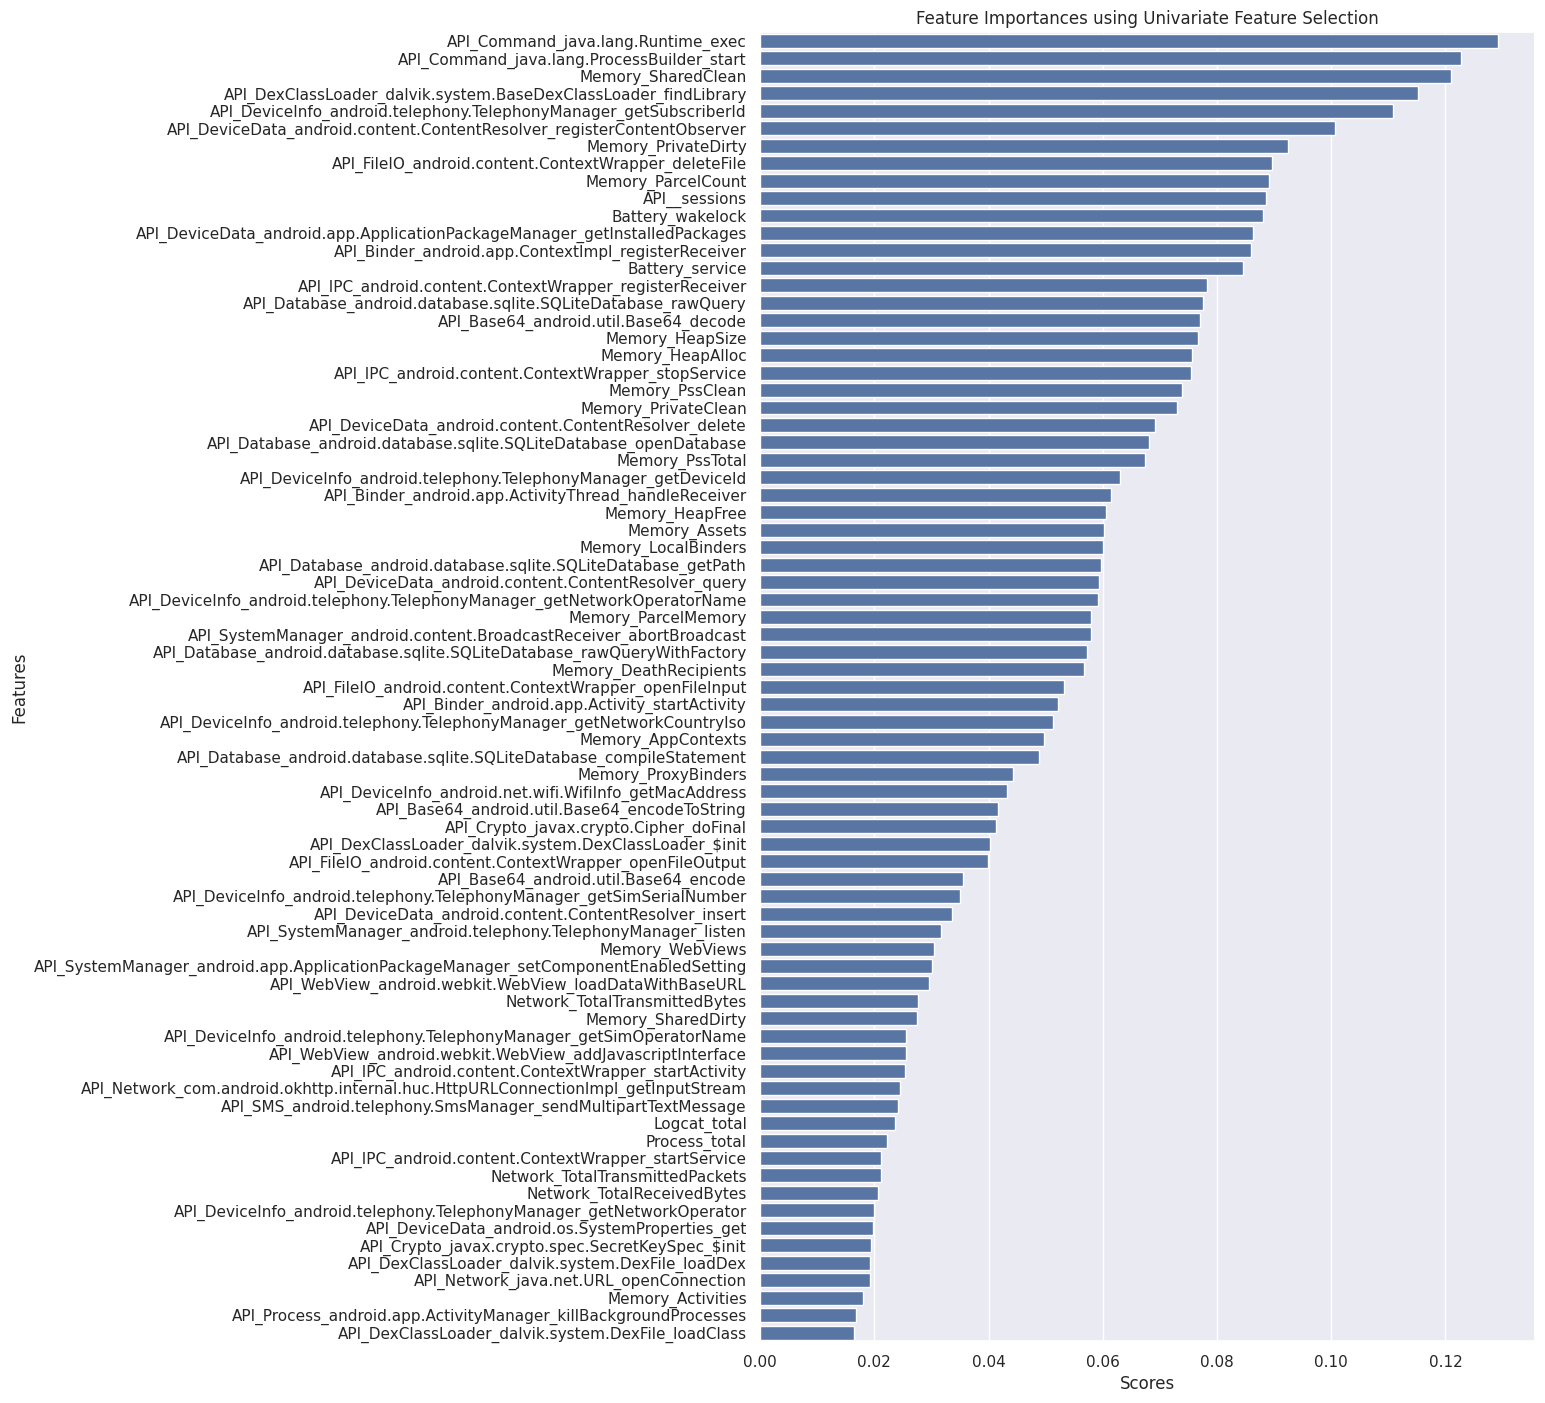

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# apply univariate feature selection
my_score = lambda X, y: mutual_info_classif(X,y, random_state=1234)
selector = SelectKBest(k=75, score_func=my_score)

# set a random state for the selector
best_features = selector.fit(only_numeric, malware_df["Category"])

# get the scores and selected features
scores = best_features.scores_
selected_features = only_numeric.columns[best_features.get_support()]

sorted_idxs = np.argsort(scores)[::-1]
sorted_scores = scores[sorted_idxs]
sorted_feature_names = np.array(only_numeric.columns)[sorted_idxs]

# plot scores
plt.figure(figsize=(10, 17))
sns.barplot(x=sorted_scores[:75], y=sorted_feature_names[:75])
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importances using Univariate Feature Selection')
plt.show()

Recordemos ademas que las variables numericas estaban divididas en las siguientes categorias: *Memory*, *Network*, *Battery*, *Logcat*, *Process* y *API.* Veamos la distribucion de las variables seleccionadas entre estas categorias.

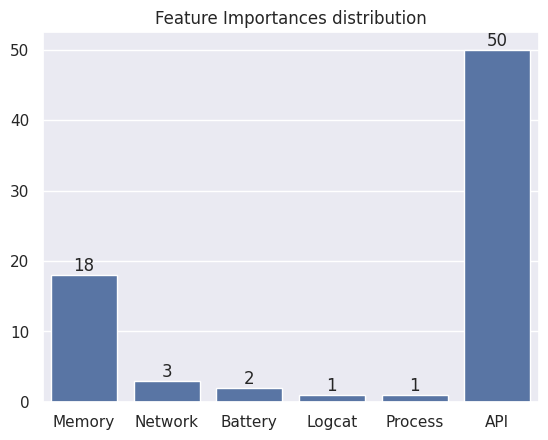

In [ ]:
feat_amount = { "feature": [],
                "amount": []}
features_groups = ["Memory", "Network", "Battery", "Logcat", "Process", "API"]
for feat in features_groups:
  feat_amount["feature"].append(feat)
  feat_amount["amount"].append(len([f for f in selected_features
                                    if feat == f.split("_")[0]]))
ax = sns.barplot(x=feat_amount["feature"], y=feat_amount["amount"])
ax.bar_label(ax.containers[0])
plt.title('Feature Importances distribution');

Con este podemos ver que las de las 75 variables seleccionadas 50 correponden al grupo API, siendo este grupo el mas numero. Le siguen en importancia las variables del grupo Memory. Las variables de Network y Battery aportan 3 y 2 respectivamente, mientras que las variables Process y Logcat solo una.

## **Clustering Jerarquico**

Dado que aun tenemos 75 variables, veamos si podemos aplicar clustering para reducir la cantidad de variables a usar en un modelo.

El clustering jerárquico es usado para agrupar instancias similares en un dataset, creando una estructura de árbol. A medida que bajamos las instancias son agrupadas en grupos. Se puede usar esto para agrupar las variables (columnas) en lugar de las instancias (filas).

En nuestra aplicación usamos el método de Ward para calcular la distancia entre clases.

Es importante escalar los datos antes de aplicar el clustering.

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

In [ ]:
# Seleccionamos las variables importantes para el modelo
df_feat = malware_df[list(selected_features)]

# Escalamos los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_feat)
df_scaled = pd.DataFrame(df_scaled, columns=df_feat.columns)

El proximo paso es trasponer la matriz. Como se mencionó, al trasponer la matriz se termina con una fila para cada feature y una columna para cada instancia de malware.

In [ ]:
# Trasponenmos la matriz y ahora cada fila es una feature
df_transposed = df_scaled.transpose()
df_transposed.shape

(75, 45279)

Usamos la funcin ```linkage``` para realizar el clustering herarquico usando como parametros la distancia euclidea y el metodo de Ward para calcular la distancia entre clústers. Esto produce una matriz con forma (74, 4) que contiene los 74 pasos del clústering.

In [ ]:
# Realizar clustering jerarquico sobre las features
linked = linkage(df_transposed, method="ward", metric="euclidean")
linked.shape

(74, 4)

Con esto podemos crear un DataFrame con la matriz resultante, donde ```c1``` y ```c2``` dan los indexes de los 2 cluster incluidos en el nuevo cluster durante ese paso, ```distance``` es la distancia entre los 2 nuevos clúster y ```size``` es el nùmero de features en el clúster resultante.

In [ ]:
df_linked = pd.DataFrame(linked, columns=["c1", "c2", "distance", "size"])
df_linked[["c1", "c2", "size"]] = df_linked[["c1", "c2", "size"]].astype("int")
df_linked.head(10)

,c1,c2,distance,size
0,1,5,28.708682,2
1,68,70,29.847238,2
2,6,7,38.790982,2
3,55,56,45.378272,2
4,19,20,49.284890,2
5,26,29,62.294626,2
6,31,57,65.190079,2
7,34,35,82.222376,2
8,0,3,94.306582,2
9,69,76,100.294685,3


Para visualizar el clústering se usa un dendrograma.  

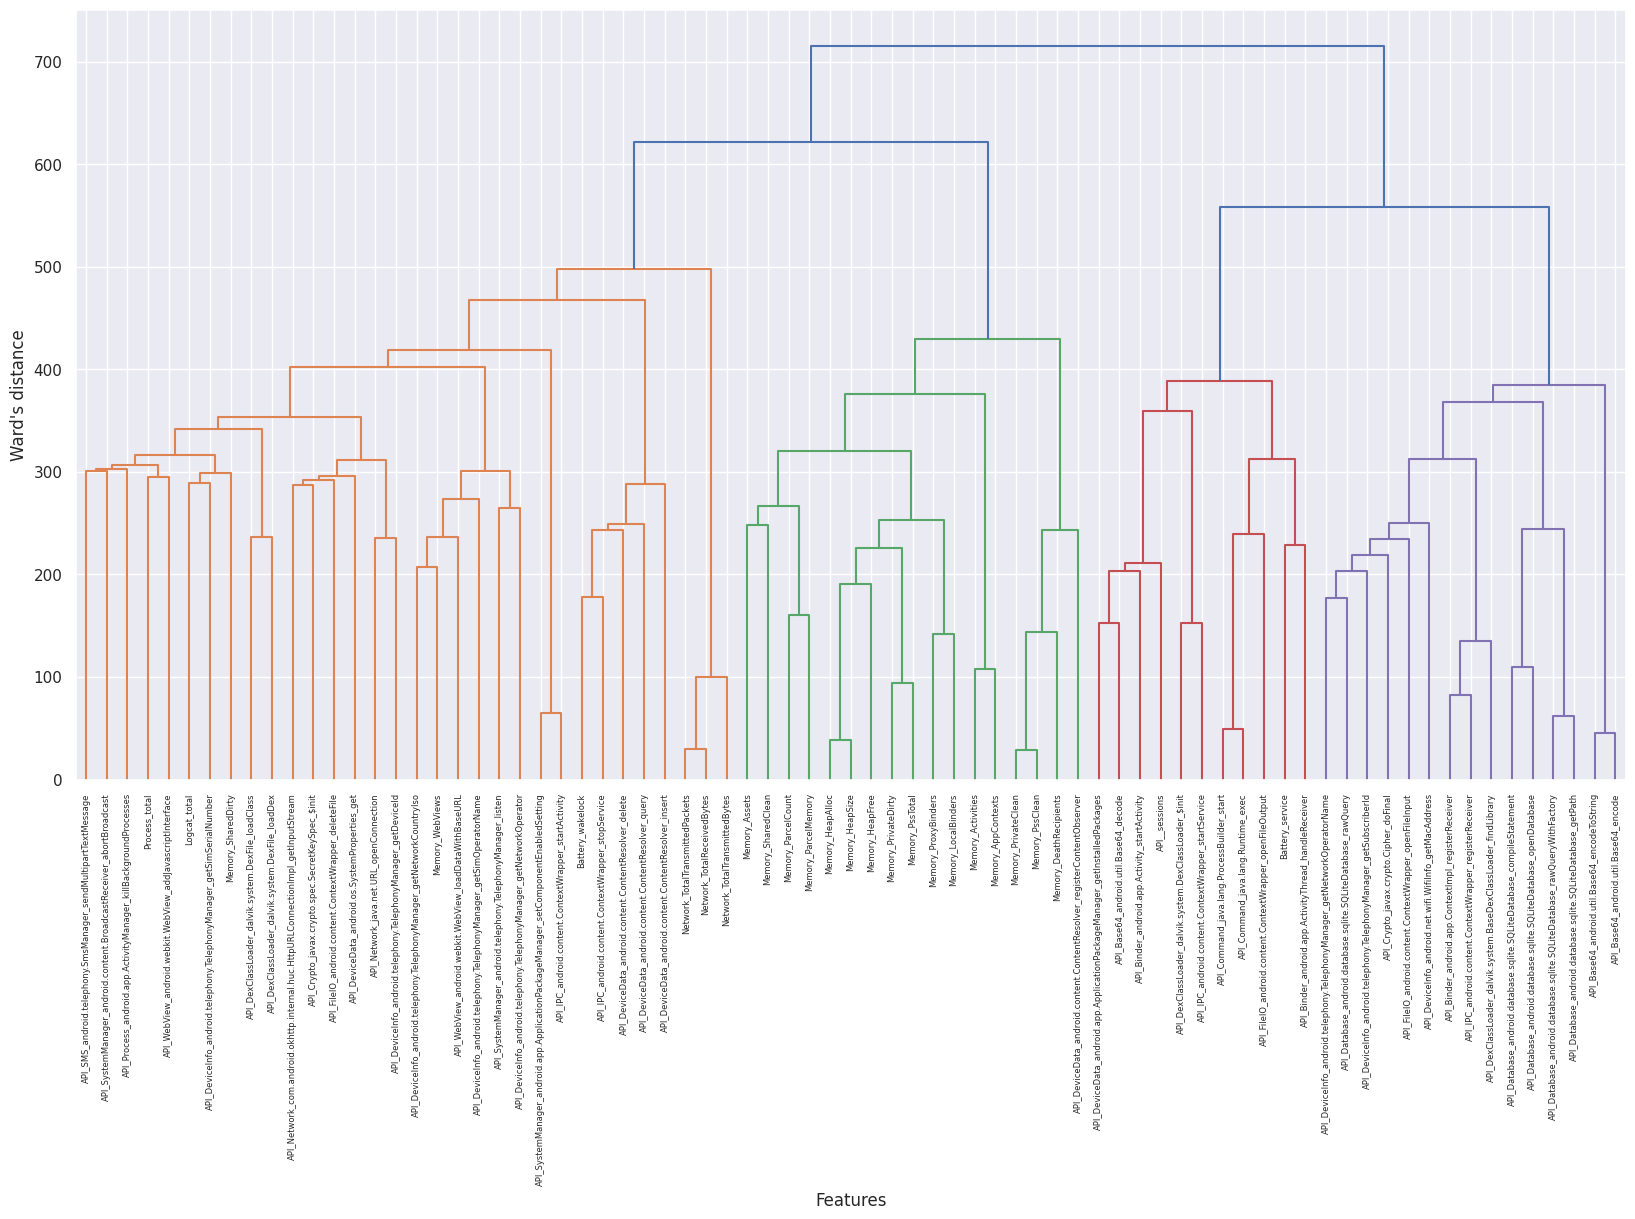

In [ ]:
plt.figure(figsize=(20, 10))

dendrogram(linked, orientation="top", labels=df_transposed.index,
           distance_sort="descending", show_leaf_counts=True)

plt.xlabel("Features")
plt.ylabel("Ward's distance");

Para seleccionar variables con clustering podemos seleccionar un máximo número de clusters y usar el limite de distancia que nos da esa cantidad de clusters.

Para eso usamos la funcion ```fcluster``` para crear un label para cada una de las 75 variables. Seteando un valor ```t```, esta función encontrara la minima distancia que nos una cantidad ```t``` de clústers. Elegir variables de estos cluser puede darnos una una lista reducida de variables. En este caso elegimos un valor ```t``` = 14 de cluster.  

In [ ]:
num_cluster = 14
labels = fcluster(linked, t=num_cluster, criterion="maxclust")

Para selecionar variables se necesita alguna medida de importancia, por que lo que usamos la prueba de la informacion mutua con la variable objetivo. Con lo cual creamos una matriz la cual nos muestra la feature, su label y la correlacion con la variable objetivo. De esta manera podemos ver las variables mas predictivas en cada clase.

In [ ]:
from sklearn.feature_selection import f_classif
correlations = mutual_info_classif(df_feat, malware_df["Category"])

df_clusters = pd.DataFrame(list(zip(df_feat.columns , labels , correlations)),
                          columns=['feature','cluster','corr'])

df_clusters.sort_values(by=['cluster','corr'], ascending=[True,False],
                        inplace=True)
df_clusters.reset_index(drop=True, inplace=True)
df_clusters.head(10)

,feature,cluster,corr
0,API_Base64_android.util.Base64_encodeToString,1,0.042308
1,API_Base64_android.util.Base64_encode,1,0.034122
2,API_Database_android.database.sqlite.SQLiteDat...,2,0.062832
3,API_Database_android.database.sqlite.SQLiteDat...,2,0.061682
4,API_Database_android.database.sqlite.SQLiteDat...,2,0.059772
5,API_Database_android.database.sqlite.SQLiteDat...,2,0.057276
6,API_DeviceInfo_android.telephony.TelephonyMana...,3,0.114094
7,API_DexClassLoader_dalvik.system.BaseDexClassL...,3,0.110693
8,API_Binder_android.app.ContextImpl_registerRec...,3,0.084209
9,API_Database_android.database.sqlite.SQLiteDat...,3,0.079275


Por ultimo podemos chequear los cluster viendo las correlaciones entre variables y usando un heapmap.

In [ ]:
c_features, c_feature_groups = [], []
feature_colors = {}
colors =colors = [ "#FF5733", "#33FF57", "#3357FF", "#FF33FF", "#33FFFF",
                   "#FF3333", "#33FF33", "#3333FF", "#FF9933", "#9933FF",
                   "#33FF99", "#FF33CC", "#800000",  "#008080"]
for k in range(1, num_cluster+1):
  cluster = df_clusters[df_clusters['cluster']==k]['feature'].tolist()
  color = colors[k-1]
  c_feature_groups.append(cluster)
  for j in range(len(cluster)):
    c_features.append(cluster[j])
    feature_colors[cluster[j]] = color

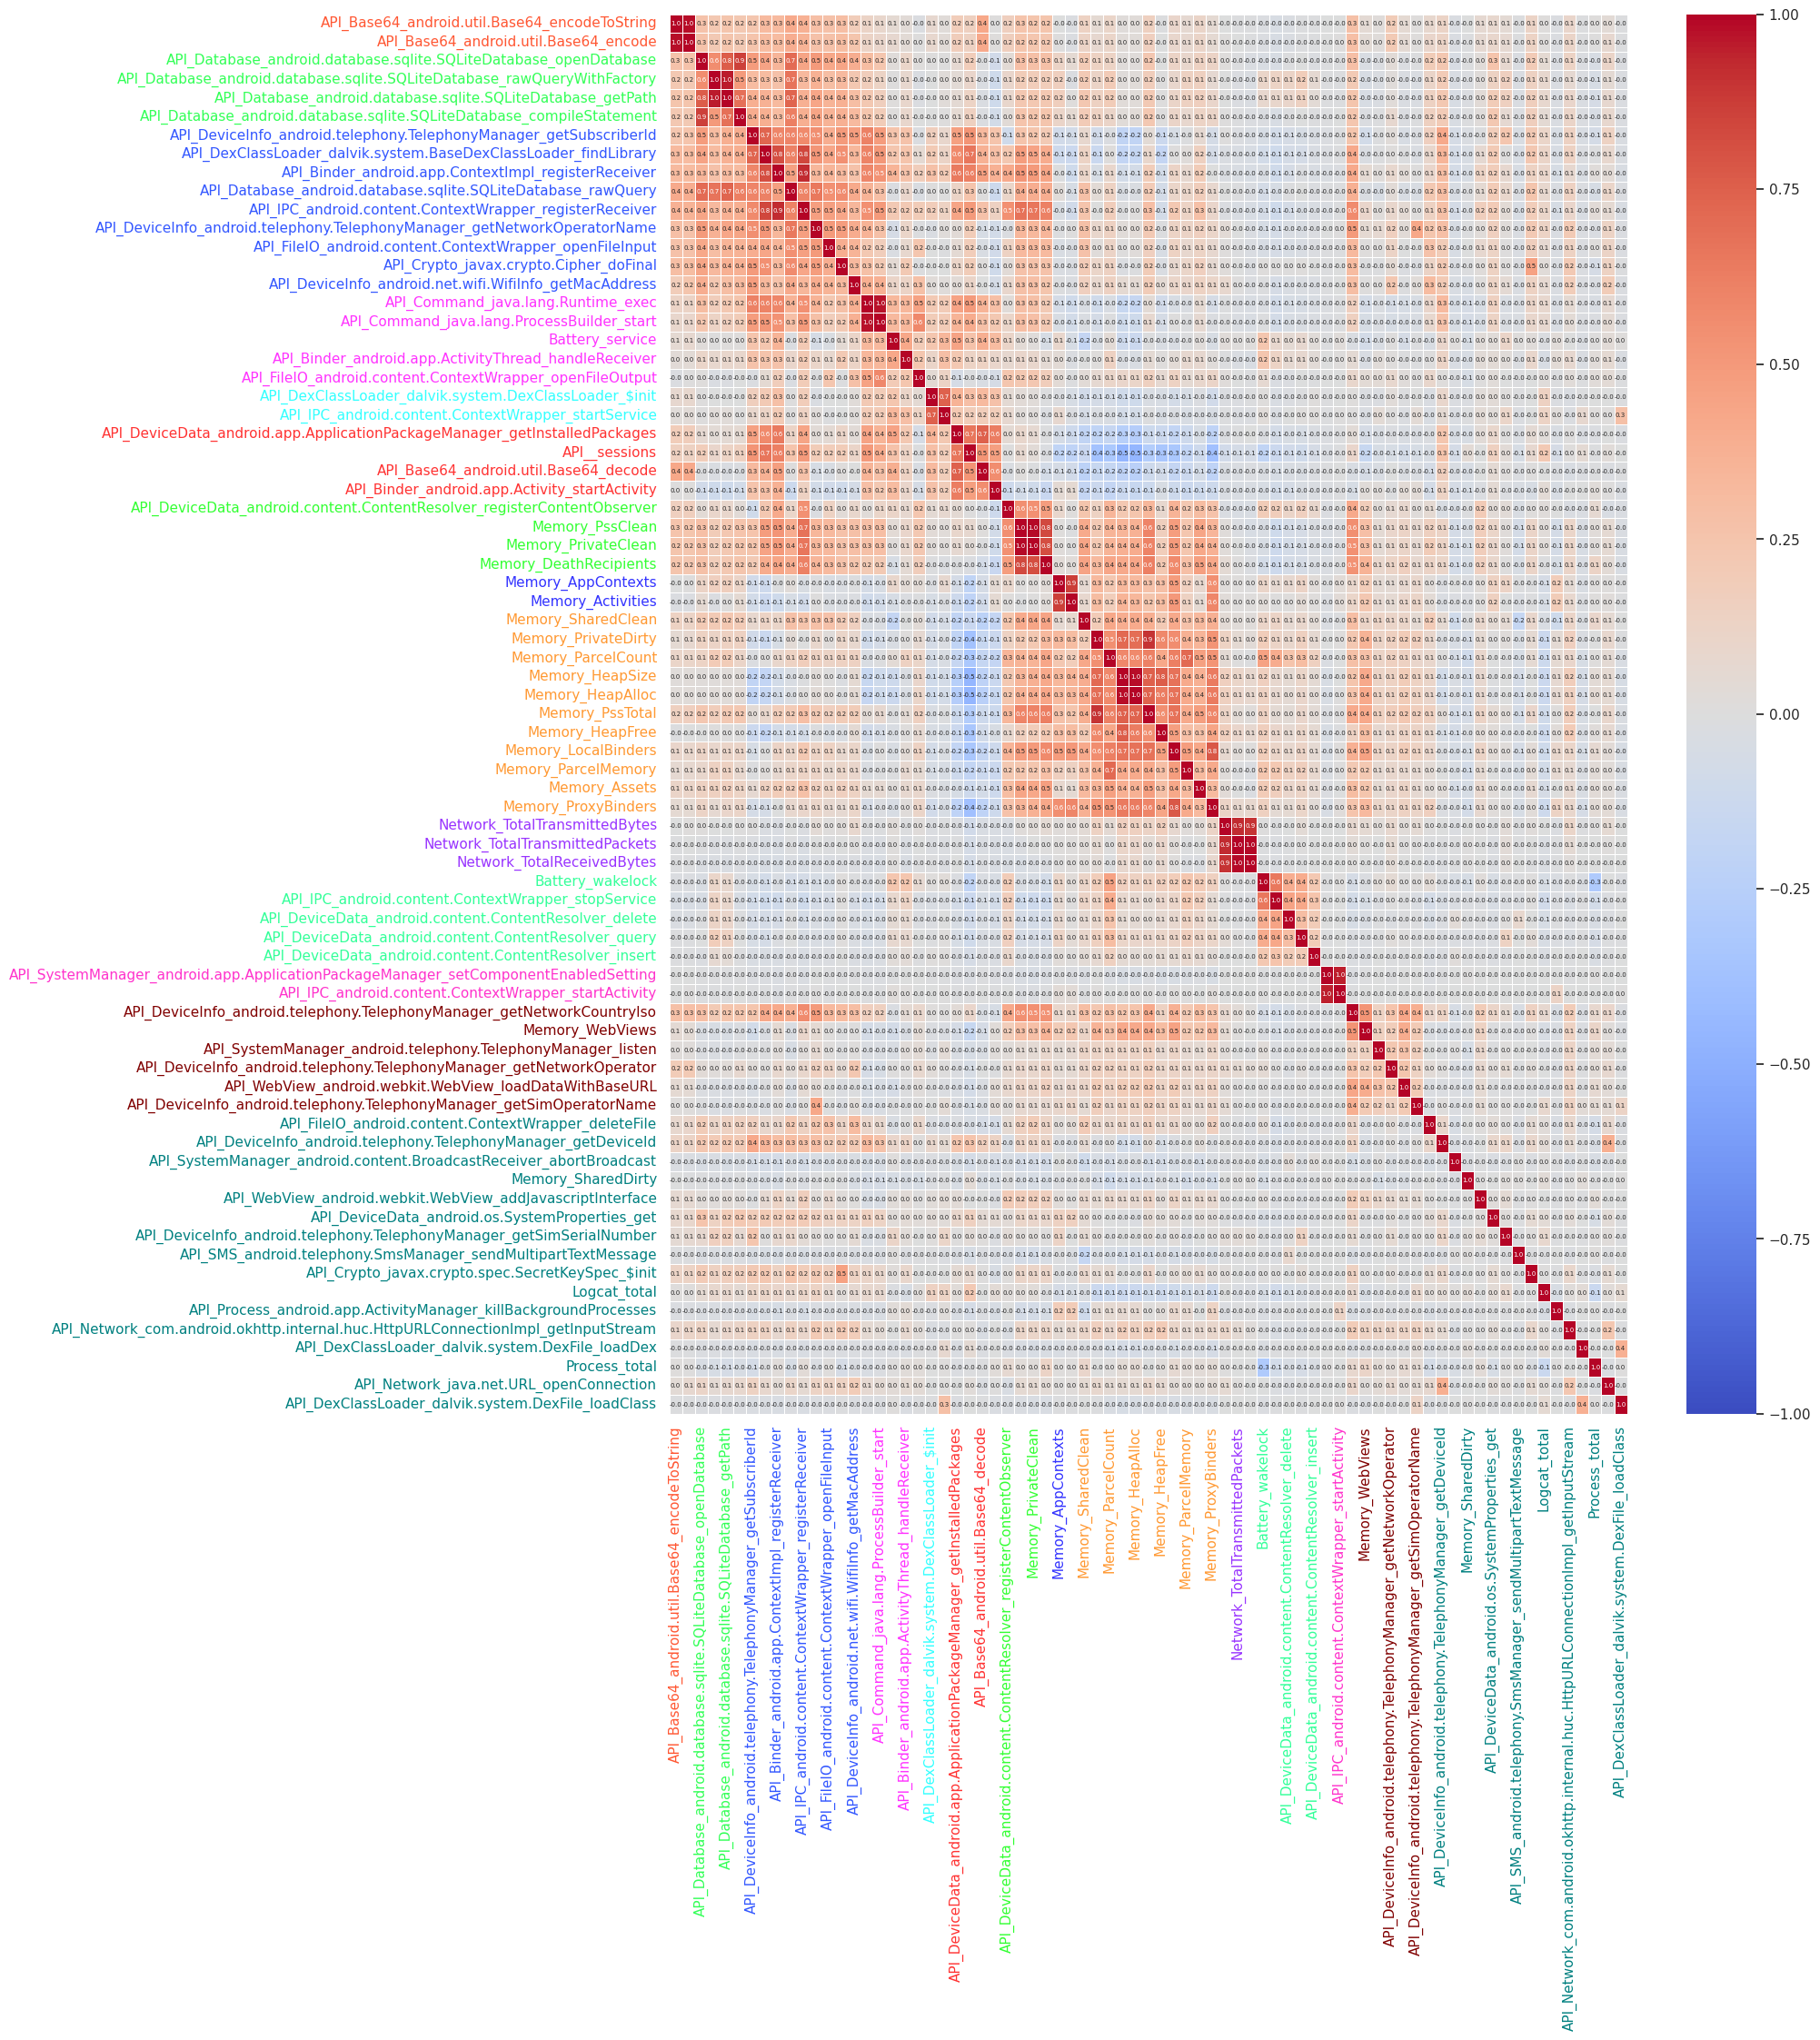

In [ ]:
# Plot correlations for features in cluste
corr = df_feat[c_features].corr()
# plot correlation matrix
plt.figure(figsize=(17,20))
heatmap = sns.heatmap(corr,
                      annot=True,
                      cmap='coolwarm',
                      linewidths=0.5,
                      fmt=".1f",
                      annot_kws={"size": 5},
                      vmin=-1, vmax=1)

highlight_cols = c_feature_groups[0]
highlight_cols_group2 = c_feature_groups[1]

axis = [heatmap.get_xticklabels(), heatmap.get_yticklabels()]
for ax in axis:
  for label in ax:
      color = feature_colors[label.get_text()]
      label.set_color(color)

Las features con el mismo color pertenecen a un mismo clúster. Puede observarse en la mayoria de los clúster obtenidos existe alta correlación con las otras features de su clúster. Si se eligen 1, 2 o mas features de cada clúster se puede reducir la cantidad de variables para el modelo. La idea es terminar con un conjunto de variables que no esté altamente correlacionado.

Aplicando este método nos quedamos con la siguiente 30 variables.

In [ ]:
new_selected_columns = ["API_DeviceInfo_android.telephony.TelephonyManager_getDeviceId",
                        "API_Command_java.lang.ProcessBuilder_start",
                        "API_FileIO_android.content.ContextWrapper_deleteFile",
                        "API_DeviceInfo_android.net.wifi.WifiInfo_getMacAddress",
                        "API_Binder_android.app.Activity_startActivity",
                        "API_DeviceInfo_android.telephony.TelephonyManager_getSubscriberId",
                        "API_DexClassLoader_dalvik.system.BaseDexClassLoader_findLibrary",
                        "API_Binder_android.app.ContextImpl_registerReceiver",
                        "API_Binder_android.app.ActivityThread_handleReceiver",
                        "API_Command_java.lang.Runtime_exec",
                        "API_IPC_android.content.ContextWrapper_startService",
                        "API_IPC_android.content.ContextWrapper_registerReceiver",
                        "API__sessions",
                        "API_DeviceData_android.content.ContentResolver_registerContentObserver",
                        "Memory_PssClean",
                        "Memory_PrivateClean",
                        "Memory_PssTotal",
                        "Memory_LocalBinders",
                        "Memory_SharedClean",
                        "Memory_ParcelCount",
                        "Memory_ParcelMemory",
                        "Memory_HeapAlloc",
                        "Memory_HeapFree",
                        "Memory_HeapSize",
                        "Memory_PrivateDirty",
                        "Memory_SharedDirty",
                        "API_DeviceData_android.os.SystemProperties_get",
                        "API_Network_java.net.URL_openConnection",
                        "Network_TotalTransmittedBytes",
                        "Logcat_total"]
len(set(new_selected_columns))

30

## **Reducción de dimensionalidad**

Aplicaremos PCA (Principal Component Analysis) para reducir aún mas la dimensionalidad, realizar algunas visualizaciones y poder aplicar metodos de clasificacion basados en distancia como logistic regresion.

Para aplicar esta tecnica necesitamos escalar las variables.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Select the importance variables for the model
X = malware_df[list(new_selected_columns)]

# Standard Scaling
scaler = StandardScaler()
scaler.fit(X)
scaled_data = scaler.transform(X)
scaled_data = pd.DataFrame(scaled_data, columns=X.columns)

# Min Max Scaling
minmax = MinMaxScaler()
minmax.fit(X)
minmax_data = minmax.transform(X)
minmax_data = pd.DataFrame(minmax_data, columns=X.columns)

# Standard Scaling
scaler = RobustScaler()
scaler.fit(X)
scaled_robust_data = scaler.transform(X)
scaled_robust_data = pd.DataFrame(scaled_robust_data, columns=X.columns)

### Label Encoding para variables target

Dado que algunas algoritmos de clasificacion necesitan que las variables target sean numericas, realizamos este encoding en este momento.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le_cat = LabelEncoder()
malware_df["Category_encod"] = le_cat.fit_transform(malware_df["Category"])
le_fam = LabelEncoder()
malware_df["Family_encod"] = le_fam.fit_transform(malware_df["Family"])

# Encoded values
y_cat = malware_df["Category_encod"].values
y_fam = malware_df["Family_encod"].values

Luego escalamos los datos y realizamos una visualización para cada escalado, viendo como varía la varianza explicada para 2 componentes segun la técnica empleada.

Con  Standard Scaling
	 * La varianza explicada con dos componentes es 42.750 %.
Con  MinMaxScaler
	 * La varianza explicada con dos componentes es 73.326 %.
Con  Robust Scaling
	 * La varianza explicada con dos componentes es 96.754 %.


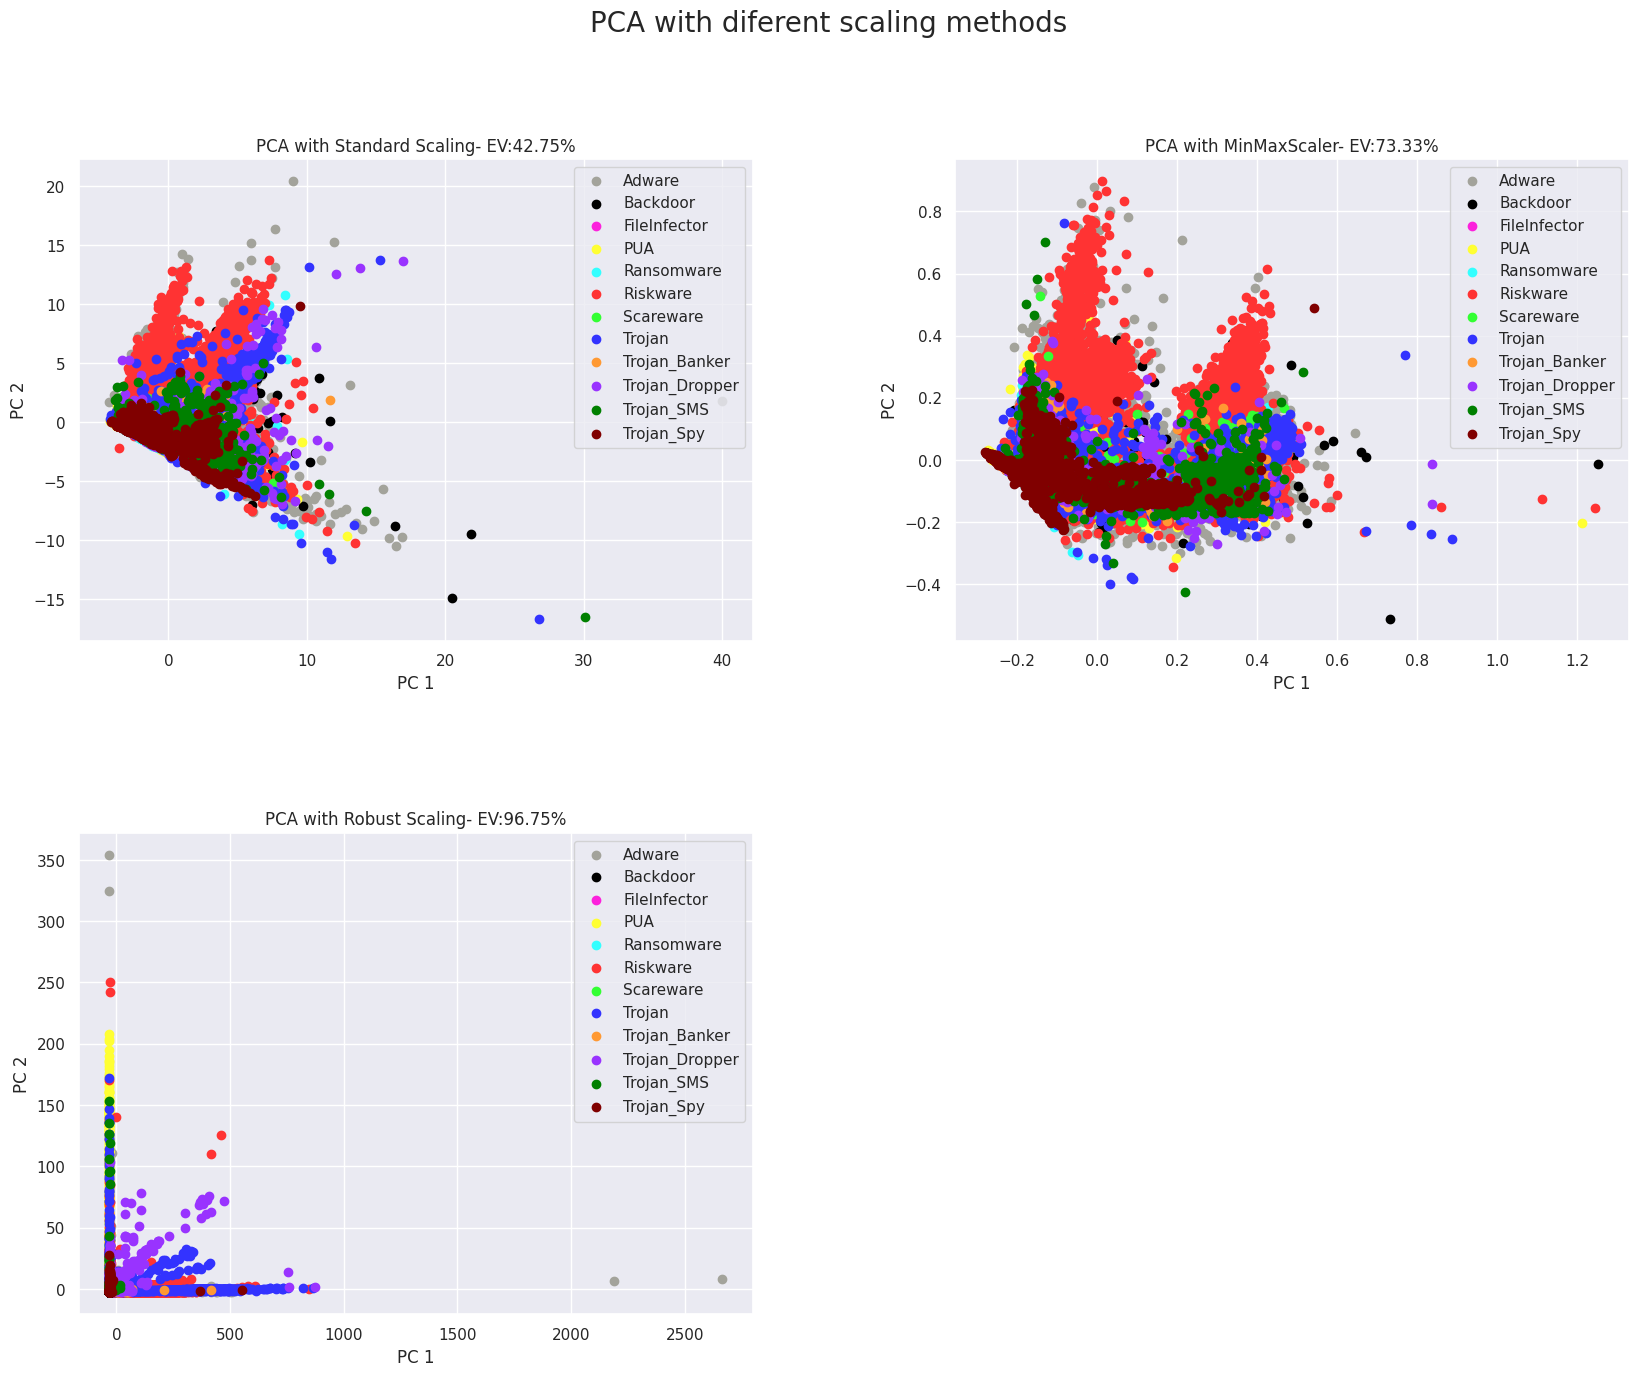

In [ ]:
from sklearn.decomposition import PCA

datas = {'Standard Scaling': scaled_data,
         'MinMaxScaler': minmax_data,
         'Robust Scaling': scaled_robust_data}

colors_malware =  [
    "#A3A39B", "#000000", "#FC21DC", "#FFFF33", "#33FFFF",
    "#FF3333", "#33FF33", "#3333FF", "#FF9933", "#9933FF",
    "#008000", "#800000"
]
order_malwares =  le_cat.inverse_transform(np.unique(y_cat))
fig = plt.figure(figsize=(20,15))
for idx, scl in enumerate(datas.keys()):
    ax = fig.add_subplot(2, 2, idx+1)
    # PCA transformation:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(datas[scl])
    colors = colors_malware
    labels = order_malwares
    print('Con ', scl)
    v_expl = sum(pca.explained_variance_ratio_[:2])*100
    print('\t * La varianza explicada con dos componentes es %2.3f %%.' % v_expl)
    # Plot PCA
    for l, c in zip(np.unique(y_cat), colors):
        ax.scatter(X_pca[y_cat==l, 0],
                   X_pca[y_cat==l, 1],
                   c=c, label=labels[l])
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.legend(loc='best')
        ax.set_title('PCA with ' + scl + '- EV:' + str(np.round(v_expl, 2)) + '%')
fig.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle('PCA with diferent scaling methods', fontsize=20)
sns.set();

Puede observarse que con la técnica de *Robust Scaling* se obtiene el mejor porcentaje de varianza explicada. Esta tecnica de escalado es menos sensible a los outliers. En esta ultima visualización pueden verse algunas diferencias entre las categorias Troyanos: Trojan parece ibicarse sobre ambos ejes (x e y) y en la diagonal, Trojan_Spy en el origen, Trojan_Dropper en la diagonal mayoritariamente, Trojan_SMS en el eje y y Trojan_Banker apenas sobre el eje x.

En todos los graficos no alcanzan a visualizarse los puntos de FileInfector, recordemos que esta es la categoria con la muestra de menor tamaño.

## Entrenamiento de algoritmos

Relizaremos 10 fold cross validation para entrenar distintos algoritmos y armaremos una tabla para identificar el mejor modelo.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              BaggingClassifier)
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

Agregamos los clasificadores y hacemos una validacion usando los datos del PCA solo para Logistic Regression

In [ ]:
my_classifiers = [
    ("XGBoost", xgb.XGBClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Bagging", BaggingClassifier()),
    ("Logistic Regression", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
]

scaled_ml = ["Logistic Regression"]

In [ ]:
def KValidation(my_classifiers, y):
  total_scores = {}
  # iterate over my_classifiers
  for name, clf in my_classifiers:
    if name in scaled_ml:
      CV_X = X_pca
    else:
      CV_X = X.to_numpy()
    print("* Evaluating : %s" % name)
    kfold = StratifiedKFold(n_splits=10, shuffle=True,
                            random_state=1234).split(CV_X, y)
    scores = []
    for k, (train, test) in enumerate(kfold):
      clf.fit(CV_X[train], y[train])
      score = clf.score(CV_X[test], y[test])
      scores.append(score)
      print('\t -> Fold: %2d, Acc: %.3f' % (k+1, score))
    print('* -> Result: CV accuracy for %s : %.3f +/- %.3f' % (name,
                                                         np.mean(scores),
                                                         np.std(scores)))
    total_scores[name] = np.mean(scores)
  return total_scores

In [ ]:
total_scores_category = KValidation(my_classifiers, y_cat)

* Evaluating : XGBoost
	 -> Fold:  1, Acc: 0.847
	 -> Fold:  2, Acc: 0.852
	 -> Fold:  3, Acc: 0.865
	 -> Fold:  4, Acc: 0.851
	 -> Fold:  5, Acc: 0.848
	 -> Fold:  6, Acc: 0.851
	 -> Fold:  7, Acc: 0.860
	 -> Fold:  8, Acc: 0.854
	 -> Fold:  9, Acc: 0.853
	 -> Fold: 10, Acc: 0.859
* -> Result: CV accuracy for XGBoost : 0.854 +/- 0.005
* Evaluating : Random Forest
	 -> Fold:  1, Acc: 0.865
	 -> Fold:  2, Acc: 0.869
	 -> Fold:  3, Acc: 0.874
	 -> Fold:  4, Acc: 0.869
	 -> Fold:  5, Acc: 0.867
	 -> Fold:  6, Acc: 0.867
	 -> Fold:  7, Acc: 0.872
	 -> Fold:  8, Acc: 0.869
	 -> Fold:  9, Acc: 0.872
	 -> Fold: 10, Acc: 0.873
* -> Result: CV accuracy for Random Forest : 0.870 +/- 0.003
* Evaluating : Decision Tree
	 -> Fold:  1, Acc: 0.794
	 -> Fold:  2, Acc: 0.784
	 -> Fold:  3, Acc: 0.787
	 -> Fold:  4, Acc: 0.792
	 -> Fold:  5, Acc: 0.795
	 -> Fold:  6, Acc: 0.778
	 -> Fold:  7, Acc: 0.794
	 -> Fold:  8, Acc: 0.782
	 -> Fold:  9, Acc: 0.795
	 -> Fold: 10, Acc: 0.804
* -> Result: CV accurac

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  1, Acc: 0.366


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  2, Acc: 0.320


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  3, Acc: 0.373


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  4, Acc: 0.368


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  5, Acc: 0.372


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  6, Acc: 0.368


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  7, Acc: 0.305


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  8, Acc: 0.307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  9, Acc: 0.372


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold: 10, Acc: 0.371
* -> Result: CV accuracy for Logistic Regression : 0.352 +/- 0.028
* Evaluating : KNN
	 -> Fold:  1, Acc: 0.678
	 -> Fold:  2, Acc: 0.673
	 -> Fold:  3, Acc: 0.698
	 -> Fold:  4, Acc: 0.690
	 -> Fold:  5, Acc: 0.681
	 -> Fold:  6, Acc: 0.677
	 -> Fold:  7, Acc: 0.683
	 -> Fold:  8, Acc: 0.682
	 -> Fold:  9, Acc: 0.691
	 -> Fold: 10, Acc: 0.695
* -> Result: CV accuracy for KNN : 0.685 +/- 0.008


In [ ]:
total_scores_family = KValidation(my_classifiers, y_fam)

* Evaluating : XGBoost
	 -> Fold:  1, Acc: 0.781
	 -> Fold:  2, Acc: 0.777
	 -> Fold:  3, Acc: 0.773
	 -> Fold:  4, Acc: 0.783
	 -> Fold:  5, Acc: 0.774
	 -> Fold:  6, Acc: 0.778
	 -> Fold:  7, Acc: 0.768
	 -> Fold:  8, Acc: 0.782
	 -> Fold:  9, Acc: 0.779
	 -> Fold: 10, Acc: 0.778
* -> Result: CV accuracy for XGBoost : 0.777 +/- 0.004
* Evaluating : Random Forest
	 -> Fold:  1, Acc: 0.825
	 -> Fold:  2, Acc: 0.819
	 -> Fold:  3, Acc: 0.828
	 -> Fold:  4, Acc: 0.828
	 -> Fold:  5, Acc: 0.822
	 -> Fold:  6, Acc: 0.824
	 -> Fold:  7, Acc: 0.828
	 -> Fold:  8, Acc: 0.829
	 -> Fold:  9, Acc: 0.826
	 -> Fold: 10, Acc: 0.823
* -> Result: CV accuracy for Random Forest : 0.825 +/- 0.003
* Evaluating : Decision Tree
	 -> Fold:  1, Acc: 0.722
	 -> Fold:  2, Acc: 0.718
	 -> Fold:  3, Acc: 0.726
	 -> Fold:  4, Acc: 0.722
	 -> Fold:  5, Acc: 0.718
	 -> Fold:  6, Acc: 0.719
	 -> Fold:  7, Acc: 0.714
	 -> Fold:  8, Acc: 0.726
	 -> Fold:  9, Acc: 0.725
	 -> Fold: 10, Acc: 0.724
* -> Result: CV accurac

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  1, Acc: 0.217


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  2, Acc: 0.232


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  3, Acc: 0.231


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  4, Acc: 0.216


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  5, Acc: 0.219


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  6, Acc: 0.241


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  7, Acc: 0.218


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  8, Acc: 0.222


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold:  9, Acc: 0.217


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	 -> Fold: 10, Acc: 0.237
* -> Result: CV accuracy for Logistic Regression : 0.225 +/- 0.009
* Evaluating : KNN
	 -> Fold:  1, Acc: 0.593
	 -> Fold:  2, Acc: 0.593
	 -> Fold:  3, Acc: 0.591
	 -> Fold:  4, Acc: 0.586
	 -> Fold:  5, Acc: 0.575
	 -> Fold:  6, Acc: 0.587
	 -> Fold:  7, Acc: 0.588
	 -> Fold:  8, Acc: 0.595
	 -> Fold:  9, Acc: 0.593
	 -> Fold: 10, Acc: 0.594
* -> Result: CV accuracy for KNN : 0.589 +/- 0.006


In [ ]:
scores = pd.DataFrame({'clf': list(total_scores_category.keys()),
              'accuracy': list(total_scores_category.values())})
display(scores.reset_index(drop=True, ).sort_values(by='accuracy', ascending=False))

,clf,accuracy
1,Random Forest,0.869631
0,XGBoost,0.854038
4,Bagging,0.844740
2,Decision Tree,0.790499
6,KNN,0.684931
3,AdaBoost,0.507499
5,Logistic Regression,0.352150


In [ ]:
scores = pd.DataFrame({'clf': list(total_scores_family.keys()),
              'accuracy': list(total_scores_family.values())})
display(scores.reset_index(drop=True, ).sort_values(by='accuracy', ascending=False))

,clf,accuracy
1,Random Forest,0.825062
4,Bagging,0.785176
0,XGBoost,0.777159
2,Decision Tree,0.721350
6,KNN,0.589390
5,Logistic Regression,0.225049
3,AdaBoost,0.217960


Tanto para el clasificador de categorías como el de familia, la mejor accuraccy se obtiene con *Random Forest*. *Bagging* y *XGBoost* le siguen en ambos casos. De igual manera los peores clasificadores fueron *Adaboost* y *Logistic Regression*

## Tuneo de hiperparametros con GridSearchCV

Para el mejor clasificador *Random Forest*, realizaremos una busqueda en grilla para encontrar los mejores parámetros. Esto lo haremos en esta entrega sólo para el clasificador de categorías, quedando pendiente de realizar para el otro clasificador.

Notar que se comentaron los valores probados para que al correrlo si se quiere no demore tante tiempo, pero con se probaron en total 192 modelos candidatos.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# A parameter grid for Random Forest
tuned_params = {
    # [100, 200]
    'n_estimators': [100],
    # [None, 10]
    'max_depth': [None],
    # ['gini', 'entropy']
    'criterion': ['gini'],
    # [2, 5]
    'min_samples_split': [2, 5],
    # [1, 2, 4, 6],
    'min_samples_leaf': [1],
    # ['auto', 'sqrt', 'log2']
    'max_features': ['sqrt']
}

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),
                                                    y_cat, test_size=0.20,
                                                    stratify=y_cat,
                                                    random_state=0)

scores = ['precision']

for score in scores:
    print("# Tuneando parámetros para %s" % score)
    print()

    clf = GridSearchCV(
        RandomForestClassifier(), tuned_params, scoring='%s_macro' % score,
            n_jobs=-1, verbose=2)
    clf.fit(X_train, y_train)

    print("El mejor conjunto de parámetros encontrado:")
    print()
    print(clf.best_params_)
    print()
    print("Puntajes grid:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Reporte de clasificación:")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuneando parámetros para precision

Fitting 5 folds for each of 2 candidates, totalling 10 fits
El mejor conjunto de parámetros encontrado:

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Puntajes grid:

0.849 (+/-0.027) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.849 (+/-0.030) for {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.82      0.93      0.88      2186
           1       0.90      0.66      0.76       216
           2       0.70      0.57      0.63        46
           3       0.94      0.65      0.77       248
           4       0.83      0.88      0.85       655
           5       0.91      0.91      0.91   

Luego vemos que el mejor conjunto de parametros encontrados fue:

```
{'criterion': 'gini',
'max_depth': None,
'max_features': 'auto',
'min_samples_leaf': 1,
'min_samples_split': 5,
'n_estimators': 200}
```


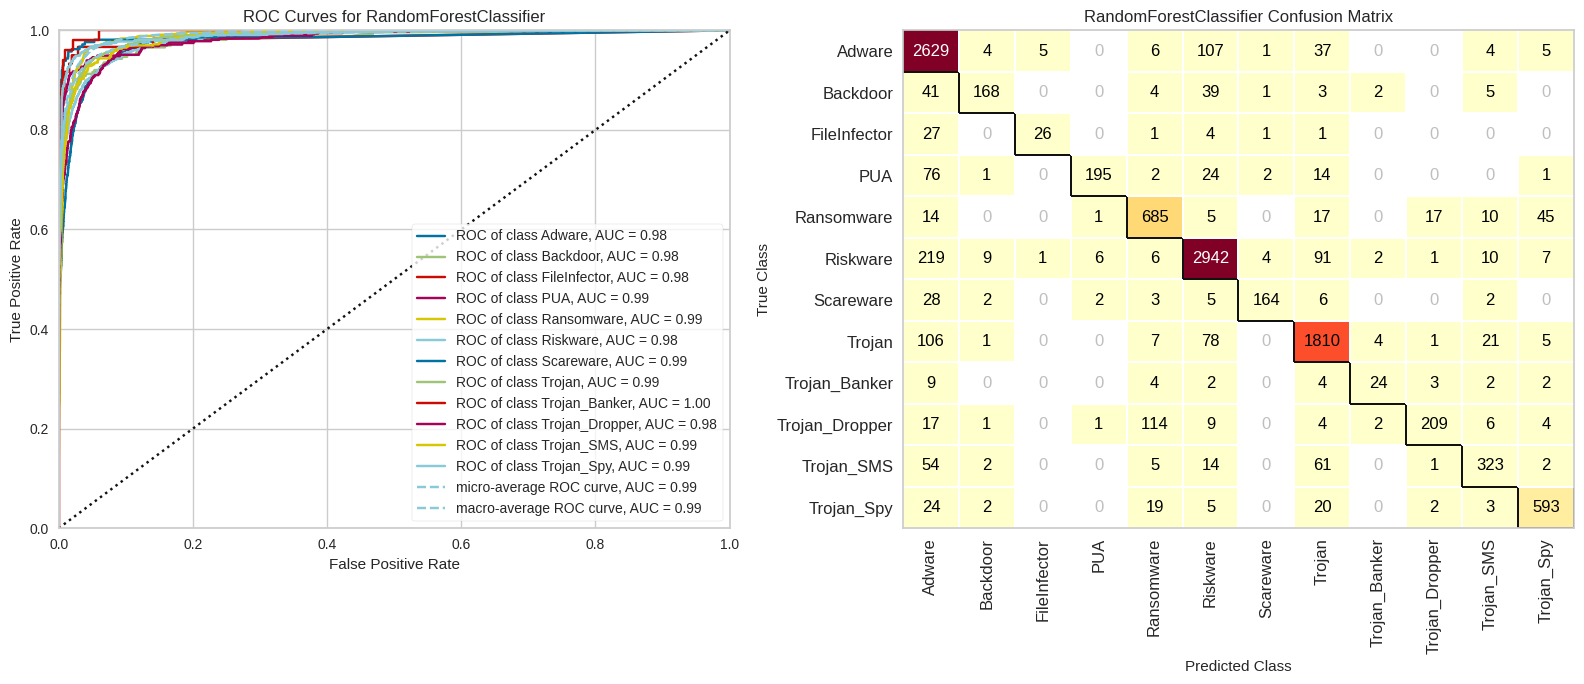

In [ ]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y_cat,
                                                    random_state=1234)

fig, axes = plt.subplots(1, 2, figsize=(16,7))
clf = RandomForestClassifier(n_estimators=200, min_samples_split=5)
clf.fit(X_train, y_train)
visualgrid = [
    ROCAUC(clf, ax=axes[0], classes=order_malwares, colors=colors_malware),
    ConfusionMatrix(clf, ax=axes[1], classes=order_malwares,
                    colors=colors_malware),
]
for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()
plt.tight_layout()

En las curvas ROC para el clasificador entrenado se observa que las areas bajo la curva son superiores a 0.98 en todos los casos, lo cual nos habla de un muy buen clasificador. FileInfector es la categoria con la precisción mas baja: casi la mitad de las muestras son catalogadas como Adware. Ransomware es la categoria con la mas alta precisión. Risware es la unica categoria que se confunde con todas las otras en alguna medida. Por otra parte todas las categorias muestran confusión con la categoria Adware.

Dentro del grupo de troyanos si bien hay confusión entre todos en alguna medida, se mal clasifican en mayor medida Trojan_SMS y Trojan entre si, que entre el resto de tipos de Troyanos.

# Bibliografia

* David Sean Keyes, Beiqi Li, Gurdip Kaur, Arash Habibi Lashkari, Francois Gagnon, Frederic Massicotte, "EntropLyzer: Android Malware Classification and Characterization Using Entropy Analysis of Dynamic Characteristics", Reconciling Data Analytics, Automation, Privacy, and Security: A Big Data Challenge (RDAAPS), IEEE, Canada, ON, McMaster University, 2021

* Abir Rahali, Arash Habibi Lashkari, Gurdip Kaur, Laya Taheri, Francois Gagnon, and Frédéric Massicotte, "DIDroid: Android Malware Classification and Characterization Using Deep Image Learning", 10th International Conference on Communication and Network Security (ICCNS2020), Pages 70–82, Tokyo, Japan, November 2020

* [Feature Selection with Hierarchical Clustering for Interpretable Models](https://towardsdatascience.com/feature-selection-with-hierarchical-clustering-for-interpretable-models-a091802f24e0)